In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import cv2 as cv
from torch.utils.tensorboard import SummaryWriter

In [4]:
def L_rate(ep, lr):
    if ep<5:
        lr = lr
    elif ep>5 and ep<8:
        lr = lr/10
    elif ep>8:
        lr = lr/50
    return lr

def train_epoch(net,dataloader,lr=0.01,optimizer=None,loss_fn = nn.NLLLoss(), writer = None, epoch = None):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    net.train()
    total_loss,acc,count = 0,0,0
    for batch_idx, (features,labels) in enumerate(dataloader):
        optimizer.zero_grad()
        out = net(features)
        loss = loss_fn(out,labels) #cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss+=loss
        _,predicted = torch.max(out,1)
        acc+=(predicted==labels).sum()
        count+=len(labels)
        img_grid = torchvision.utils.make_grid(features)
        writer.add_image("mnist images", img_grid, batch_idx)
        writer.add_histogram('fc', ConvNN.fc3.weight, batch_idx)
            
        if batch_idx%100 == 0:
            print('Train Epoch: {} [{:>5d}/{:>5d} ({:.0f}%)] \t\tLoss: {:.6f}'.format(
                epoch + 1,
                batch_idx*len(features),
                len(dataloader.dataset),
                100. * batch_idx / len(dataloader),
                loss.item()
            ))
            writer.add_scalar("Train Accuracy", acc.item()/count, epoch*60000+count)
            writer.add_scalar("Train Loss", total_loss.item()/count, epoch*6000 + count)
            
    return total_loss.item()/count, acc.item()/count

def validate(net, dataloader,loss_fn=nn.NLLLoss()):
    net.eval()
    count,acc,loss = 0,0,0
    with torch.no_grad():
        for features,labels in dataloader:
            out = net(features)
            loss += loss_fn(out,labels) 
            pred = torch.max(out,1)[1]
            acc += (pred==labels).sum()
            count += len(labels)
    return loss.item()/count, acc.item()/count

def train(net,train_loader,test_loader,optimizer=None,lr=0.01,epochs=10,loss_fn=nn.NLLLoss(), writer = None):
    optimizer = optimizer or torch.optim.Adam(net.parameters(),lr=lr)
    res = { 'train_loss' : [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for ep in range(epochs):
        tl,ta = train_epoch(net,train_loader,optimizer=optimizer,lr=lr,loss_fn=loss_fn, epoch = ep, writer = writer)
        vl,va = validate(net,test_loader,loss_fn=loss_fn)
        print(f"-----------------------------------------\nEpoch {ep+1:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}\n")
        res['train_loss'].append(tl)
        res['train_acc'].append(ta)
        res['val_loss'].append(vl)
        res['val_acc'].append(va)
    return res

def plot_results(hist):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.ylim(0, 1)
    plt.legend()
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.xlabel("epochs")
    plt.ylabel("acc")
    plt.legend()
    
def img_to_torch(img):
    rows, cols = 28, 28
    img = cv.resize(img, (rows, cols), interpolation = cv.INTER_LINEAR)
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    for row in range(rows):
        for col in range(cols):
            img[row, col] = (255 - img[row, col])
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.type(torch.FloatTensor)/255
    img = (img - 0.5)/0.5
    img = img.permute(0, 1, 2)
    return img

def load_mnist(batch_size = 32):
    transform1 = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor(),
         torchvision.transforms.Normalize((0.5, ), (0.5, ))])
    train_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = True,
        transform = transform1
    )
    test_data = torchvision.datasets.MNIST(
        root = './data',
        download = True,
        train = False,
        transform = transform1
    )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)
    
    return train_data, test_data, train_loader, test_loader


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), padding=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5))

        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.avg_pool2d(x, kernel_size=2, stride=2)
        # x = x.view(-1, 16*5*5)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.5)
        x = self.fc3(x)
        output = F.softmax(x, dim = 1)
        return output
    
ConvNN = ConvNN().to(device)

In [6]:
summary(ConvNN, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNN                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─Conv2d: 1-2                            [1, 16, 10, 10]           2,416
├─Linear: 1-3                            [1, 120]                  48,120
├─Linear: 1-4                            [1, 84]                   10,164
├─Linear: 1-5                            [1, 10]                   850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.30

In [7]:
train_data, test_data, train_loader, test_loader= load_mnist()
learning_rate = 1e-3
opt = torch.optim.Adam(ConvNN.parameters(), lr = learning_rate)
log_dir = "./CNNmnist/"
writer = SummaryWriter(log_dir)

hist = train(ConvNN, train_loader, test_loader, optimizer=opt, lr=1e-3, epochs=10, loss_fn=nn.CrossEntropyLoss(), writer = writer)
plot_results(hist)
writer.close()

Train Epoch: 1 [    0/60000 (0%)] 		Loss: 2.302557
Train Epoch: 1 [ 3200/60000 (5%)] 		Loss: 2.094852
Train Epoch: 1 [ 6400/60000 (11%)] 		Loss: 1.870755
Train Epoch: 1 [ 9600/60000 (16%)] 		Loss: 1.718068
Train Epoch: 1 [12800/60000 (21%)] 		Loss: 1.819080
Train Epoch: 1 [16000/60000 (27%)] 		Loss: 1.785656
Train Epoch: 1 [19200/60000 (32%)] 		Loss: 1.655023
Train Epoch: 1 [22400/60000 (37%)] 		Loss: 1.648241
Train Epoch: 1 [25600/60000 (43%)] 		Loss: 1.708137
Train Epoch: 1 [28800/60000 (48%)] 		Loss: 1.603039
Train Epoch: 1 [32000/60000 (53%)] 		Loss: 1.673339
Train Epoch: 1 [35200/60000 (59%)] 		Loss: 1.595695
Train Epoch: 1 [38400/60000 (64%)] 		Loss: 1.687361
Train Epoch: 1 [41600/60000 (69%)] 		Loss: 1.599601
Train Epoch: 1 [44800/60000 (75%)] 		Loss: 1.647496
Train Epoch: 1 [48000/60000 (80%)] 		Loss: 1.624401
Train Epoch: 1 [51200/60000 (85%)] 		Loss: 1.636044
Train Epoch: 1 [54400/60000 (91%)] 		Loss: 1.536964
Train Epoch: 1 [57600/60000 (96%)] 		Loss: 1.563816
--------------

ValueError: object __array__ method not producing an array

ImportError: cannot import name 'ERR_IGNORE' from 'numpy.core.umath' (/opt/anaconda3/envs/conda/lib/python3.12/site-packages/numpy/core/umath.py)

<Figure size 1500x500 with 2 Axes>

In [11]:
torch.save(ConvNN.state_dict(), "data/ConvNN.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [13]:
ConvNN.load_state_dict(torch.load("/Users/jayson/Documents/VSCODE/pytorch/data/ConvNN.pth"))

/var/folders/6q/k5hs6tzd647_yk5x07bqfxxc0000gp/T/ipykernel_6810/827249247.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ConvNN.load_state_dict(torch.load("/Users/jayso

<All keys matched successfully>

In [25]:
handwrite_list = [[]]
number = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']
for i in range(0, 10):
    numb = number[i]
    for j in range(0, 21):
        img = cv.imread(f"/Users/jayson/Documents/VSCODE/pytorch/data/handwrite/{numb}{j}.jpg")
        img = img_to_torch(img)
        handwrite_list.append([img, i])
del handwrite_list[0]

In [26]:
print(len(handwrite_list))

210


In [20]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(handwrite_list), size=(1,)).item()
    img, label = handwrite_list[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

ValueError: object __array__ method not producing an array

Error in callback <function _draw_all_if_interactive at 0x11f67ca40> (for post_execute), with arguments args (),kwargs {}:


ValueError: object __array__ method not producing an array

ValueError: object __array__ method not producing an array

<Figure size 1000x1000 with 1 Axes>

Accuracy: 83.64%


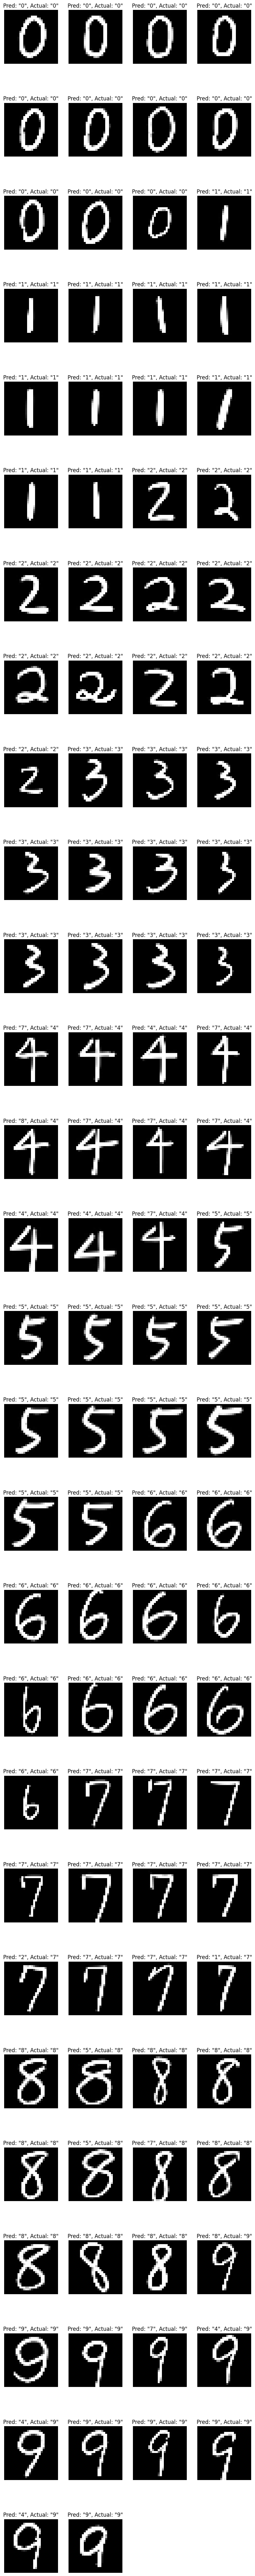

In [21]:
data_loader = torch.utils.data.DataLoader(dataset = handwrite_list, batch_size = 1)
ConvNN.eval()
figure1 = plt.figure(figsize=(10, 200))
i, j = 0, 0
for x, y in data_loader:
    figure1.add_subplot(53, 4, i+1)
    i += 1
    with torch.no_grad():
        pred = ConvNN(x)
        predicted, actual = pred[0].argmax(0), y.item()
        #print(f'Pred: "{predicted}", Actual: "{actual}"')
        plt.title(f'Pred: "{predicted}", Actual: "{actual}"')
        plt.axis("off")
        plt.imshow(x.squeeze(), cmap = "gray")
        if predicted == actual:
            j += 1
hand_acc = j/len(handwrite_list)*100
print(f"Accuracy: {hand_acc:.2f}%")
plt.show()